<a href="https://colab.research.google.com/github/RickeyEstes2/ComputationalPhysicsCourse/blob/main/09b_MC_magnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a magnet using a Monte Carlo algorithm

- by Börge Göbel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Generate starting configuration

We start with a randomly generated array of magnetic moments \\( \{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} \\). The length of each moment is fixed \\( |\vec{m}_i| = 1 \\) but the orientation is chosen randomly. We can construct this by generating a random polar angle \\( \varphi_i \\) and azimutal angle \\( \theta_i \\) and using spherical coordinates:

\\( \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} \\)

### Magnetic moments

In [19]:
length = 40
num = length**2

randphi = 2*np.pi * np.random.rand(num).reshape (length, length, 1)
randtheta = np.pi * np.random.rand(num).reshape (length, length, 1)

In [ ]:
mag = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta) ])

In [ ]:
mag[:,5,2,0]

array([ 0.9286112 , -0.03047573, -0.36980058])

In [ ]:
# Check norm
np.sqrt( mag[0,:]**2 + mag[1,:]**2 + mag[2,:]**2 )[5,2,0]

1.0

### Positions

In [ ]:
coords = np.array(np.meshgrid(np.arange(length),
                              np.arange(length),
                              np.arange(1)))

### Plot

In [ ]:
# Change standard size of all figures in this notebook
plt.rcParams['figure.figsize'] = [40, 15]

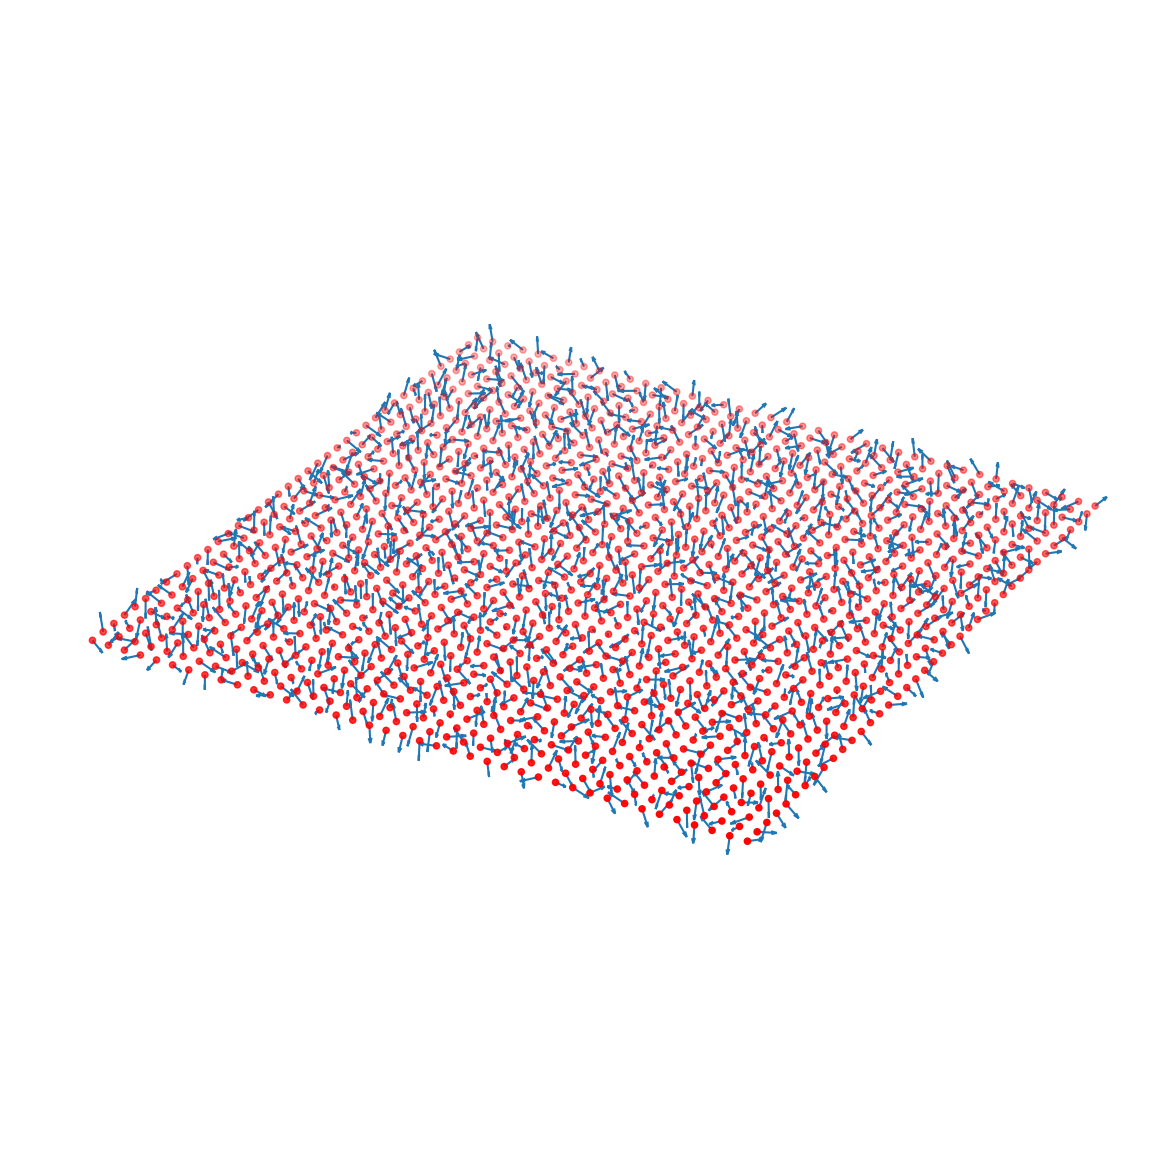

In [ ]:
arrowplot = plt.axes(projection='3d')
arrowplot.set_zlim(-1,1)
arrowplot.set_box_aspect(aspect = (length, length, 2))

# make background invisible
arrowplot.axis(False)

# Quiver plot
arrowplot.quiver(
    coords[0],coords[1],coords[2],
    mag[0],mag[1],mag[2]
    )

# Coordinate plot
arrowplot.scatter3D(coords[0],coords[1],coords[2], color='red')

## 2. Calculating the energy

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j  \\)

Every moment is interacting with its direct neighbor (\\( <i,j> \\)) and prefers a parallel orientation as long as \\( J > 0\\). Of course, there exist additional energy terms that have to be considered for a realistic ferromagnet but we will neglect them for now.

In [ ]:
J = 1

In [ ]:
def energyExchangeContribution(mag,x,y):
    return -0.5 * J * np.dot( mag[:,x,y,0], mag[:,(x+1)%length,y,0]+mag[:,(x-1)%length,y,0]+mag[:,x,(y+1)%length,0]+mag[:,x,(y-1)%length,0])

def energyExchange(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energyExchangeContribution(mag,x,y)
    return energy

In [ ]:
energyExchange(mag)

33.9698321073492

__Update 2:__ We can apply an external magnetic field \\( \vec{B} \\). This leads to the energy:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i \\)

In [ ]:
mu = 1
B = np.array([0, 0, 0])

def energyMagneticContribution(mag,x,y):
    return - mu * np.dot(B, mag[:,x,y,0])

def energyMagnetic(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energyMagneticContribution(mag,x,y)
    return energy

__Update 3:__ We include the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)\\)

The vectors \\( \vec{D}_{ij} \\) are determined by the symmetry of the sample. In our example, they shall point along the direction \\( i \rightarrow j\\).

As an example, let us consider a bond along the \\( x \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)\\)

For a bond along the \\( y \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)\\)

In [ ]:
D = 0.3

def energyDMIContribution(mag,x,y):
    right = mag[1,x,y,0]*mag[2,(x+1)%length,y,0] - mag[2,x,y,0]*mag[1,(x+1)%length,y,0]
    left = -mag[1,x,y,0]*mag[2,(x-1)%length,y,0] + mag[2,x,y,0]*mag[1,(x-1)%length,y,0]
    up = mag[2,x,y,0]*mag[0,x,(y+1)%length,0] - mag[0,x,y,0]*mag[2,x,(y+1)%length,0]
    down = -mag[2,x,y,0]*mag[0,x,(y-1)%length,0] + mag[0,x,y,0]*mag[2,x,(y-1)%length,0]
    return 0.5 * D * (right + left + up + down)

def energyDMI(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energyDMIContribution(mag,x,y)
    return energy

## 3. Metropolis step

Now to the actual Monte Carlo algorithm. We will repeditly do so-called Metropolis steps:

1. A random magnetic moment is selected.
2. It is reoriented along a random direction.
3. The energy is calculated \\( E_\mathrm{new} \\).
4. The energy is compared to the old energy \\( E_\mathrm{old} \\):
    - If the energy is decreased, the random change of the magnetic moment is accepted.
    - If the energy is increased, the old magnetic moment is restored.

In [ ]:
def stepExchange(mag):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energyold = 2 * energyExchangeContribution(mag,x,y)
    # 2.
    randphi = 2*np.pi * np.random.rand()
    randtheta = np.pi * np.random.rand()
    # Problem with the ids: savemag = mag[:,x,y,0] ==> savemag will be changed once mag[:,x,y,0] is changed in the next line
    savemag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta) ])
    # 3.
    energynew = 2 * energyExchangeContribution(mag,x,y)
    # 4.
    if ( energynew < energyold):
        # accept the change & update the energy
        energychange = energynew - energyold
    else:
        # decline & restore old moment
        mag[:,x,y,0] = savemag
        energychange = 0
    return [mag, energychange]

In [ ]:
stepExchange(mag)[1]

0

__Update 1:__ For finite temperatures \\( T \\), we accept the change with a chance \\( \exp\left(-\frac{E_\mathrm{new}-E_\mathrm{old}}{k_BT}\right) \\)

In [20]:
def stepExchangeT(mag, kBtemp):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energyold = 2 * energyExchangeContribution(mag,x,y)
    # 2.
    randphi = 2*np.pi * np.random.rand()
    randtheta = np.pi * np.random.rand()
    # Problem with the ids: savemag = mag[:,x,y,0] ==> savemag will be changed once mag[:,x,y,0] is changed in the next line
    savemag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta) ])
    # 3.
    energynew = 2 * energyExchangeContribution(mag,x,y)
    # 4.
    if ( energynew < energyold):
        # accept the change & update the energy
        energychange = energynew - energyold
    else:
        if np.random.rand() < np.exp( -(energynew - energyold) / kBtemp ):
            # accept the change & update the energy
            energychange = energynew - energyold
        else:
            # decline & restore old moment
            mag[:,x,y,0] = savemag
            energychange = 0
    return [mag, energychange]

__Update 2:__ We include the energy corresponding to the interaction with the magnetic field:

__Update 3:__ We include the energy corresponding to the Dzyaloshinskii–Moriya interaction (asymmetric exchange):

In [ ]:
def stepT(mag, kBtemp):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energyold = 2 * energyExchangeContribution(mag,x,y) + energyMagneticContribution(mag,x,y) + 2 * energyDMIContribution(mag,x,y)
    # 2.
    randphi = 2*np.pi * np.random.rand()
    randtheta = np.pi * np.random.rand()
    # Problem with the ids: savemag = mag[:,x,y,0] ==> savemag will be changed once mag[:,x,y,0] is changed in the next line
    savemag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta) ])
    # 3.
    energynew = 2 * energyExchangeContribution(mag,x,y) + energyMagneticContribution(mag,x,y) + 2 * energyDMIContribution(mag,x,y)
    # 4.
    if ( energynew < energyold):
        # accept the change & update the energy
        energychange = energynew - energyold
    else:
        if np.random.rand() < np.exp( -(energynew - energyold) / kBtemp ):
            # accept the change & update the energy
            energychange = energynew - energyold
        else:
            # decline & restore old moment
            mag[:,x,y,0] = savemag
            energychange = 0
    return [mag, energychange]

## 4. Run the Monte Carlo algorithm

In [ ]:
numberSteps = 10000000

#optional
# energy = energyExchange(mag)
energy = energyExchange(mag) + energyMagnetic(mag) + energyDMI(mag)
energyList = [energy]

for i in range(numberSteps):
    # mag, energychange = stepExchange(mag)          # Initial version: zero temperature
    kBtemp = 0.2*(1-i/numberSteps)
    # mag, energychange = stepExchangeT(mag,kBtemp)  # Update 1: Consider finite temperatures
    mag, energychange = stepT(mag,kBtemp)            # Update 2&3: Add interaction with magnetic field & DMI
    #optional
    energy = energy + energychange
    energyList.append(energy)

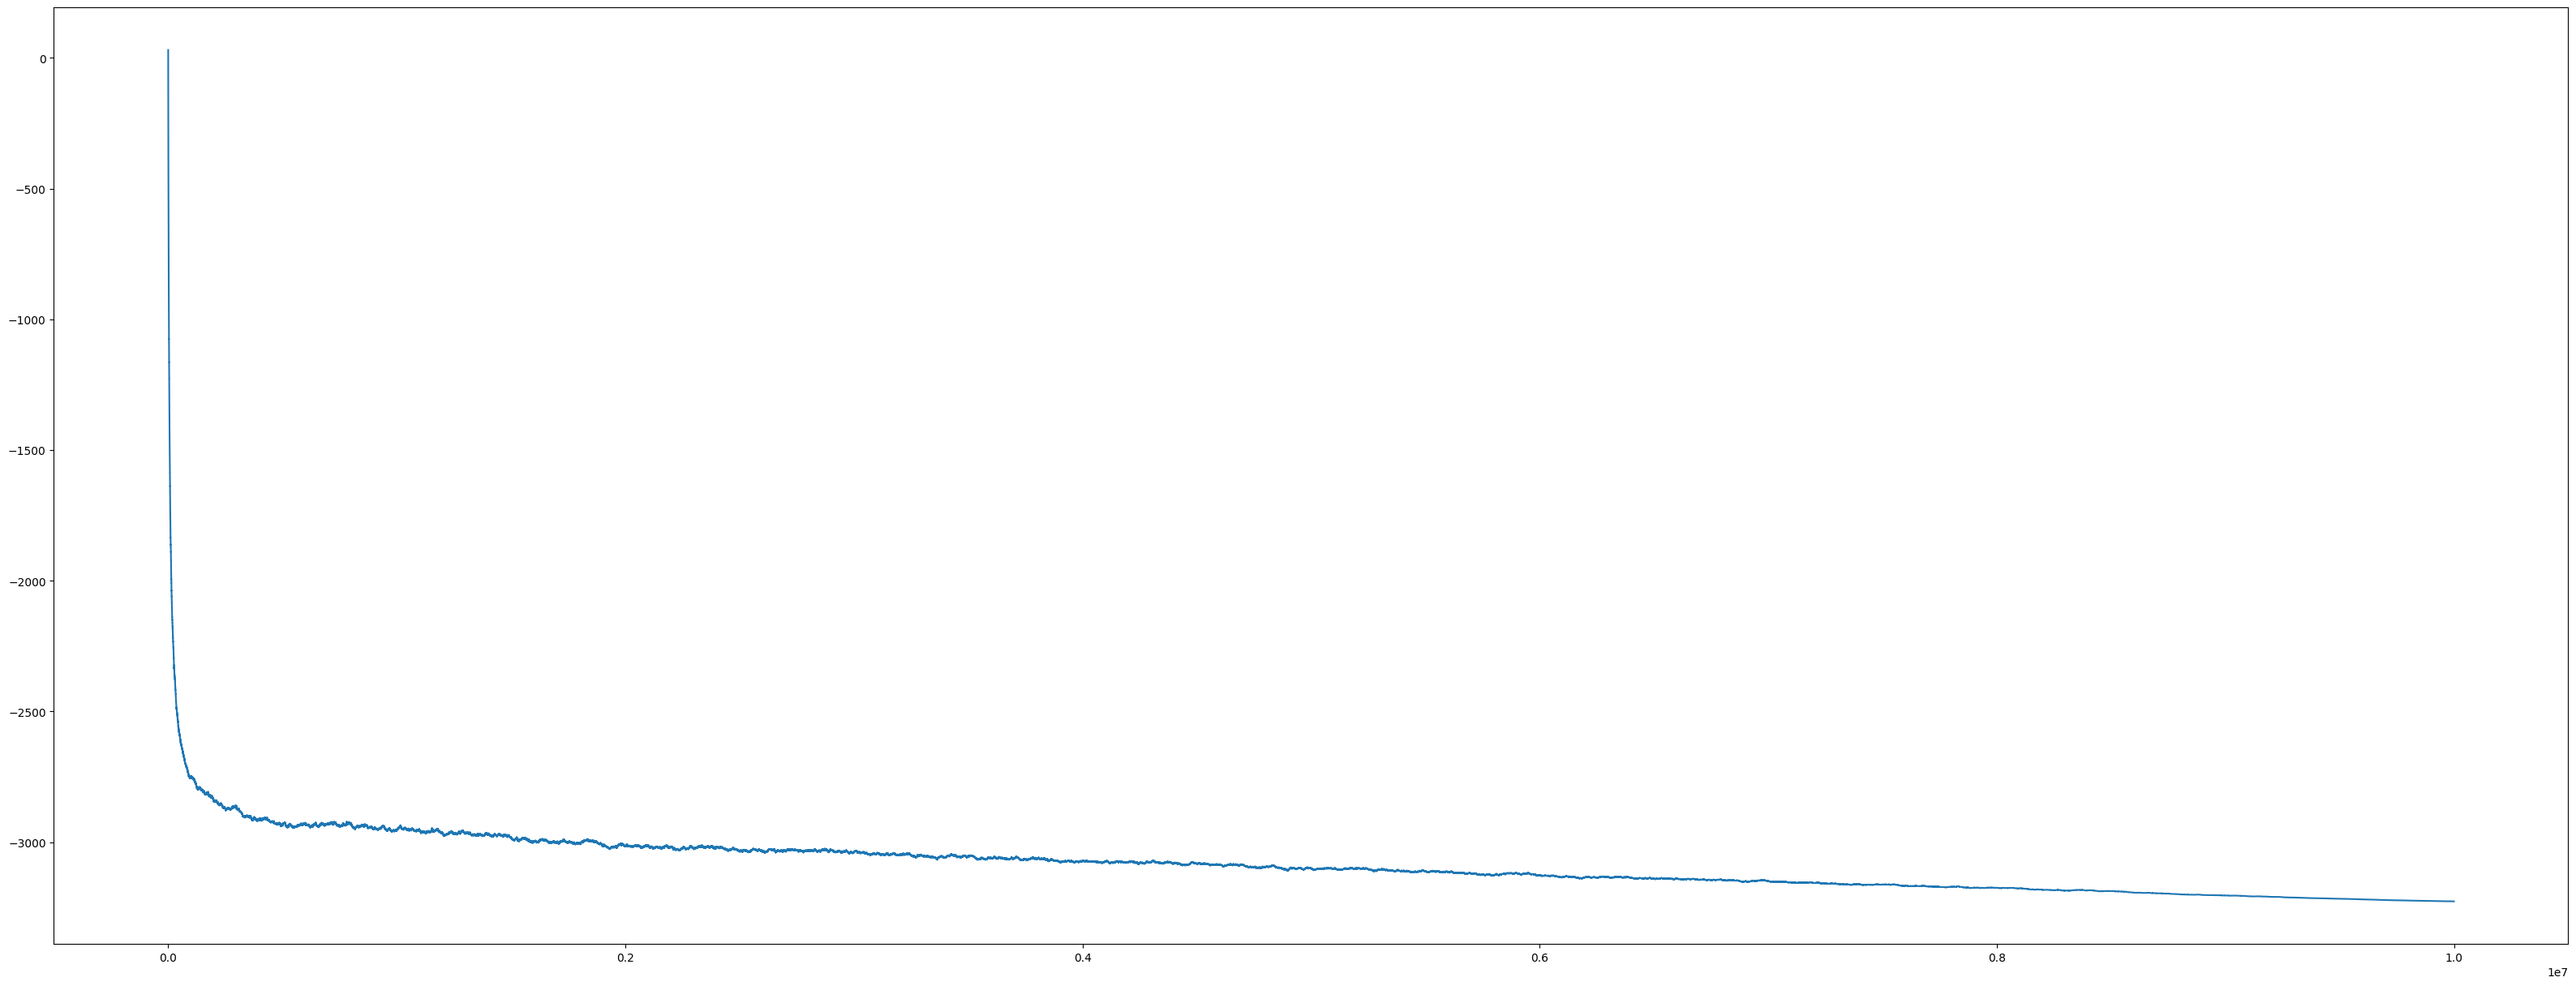

In [21]:
plt.plot(range(numberSteps+1), energyList)

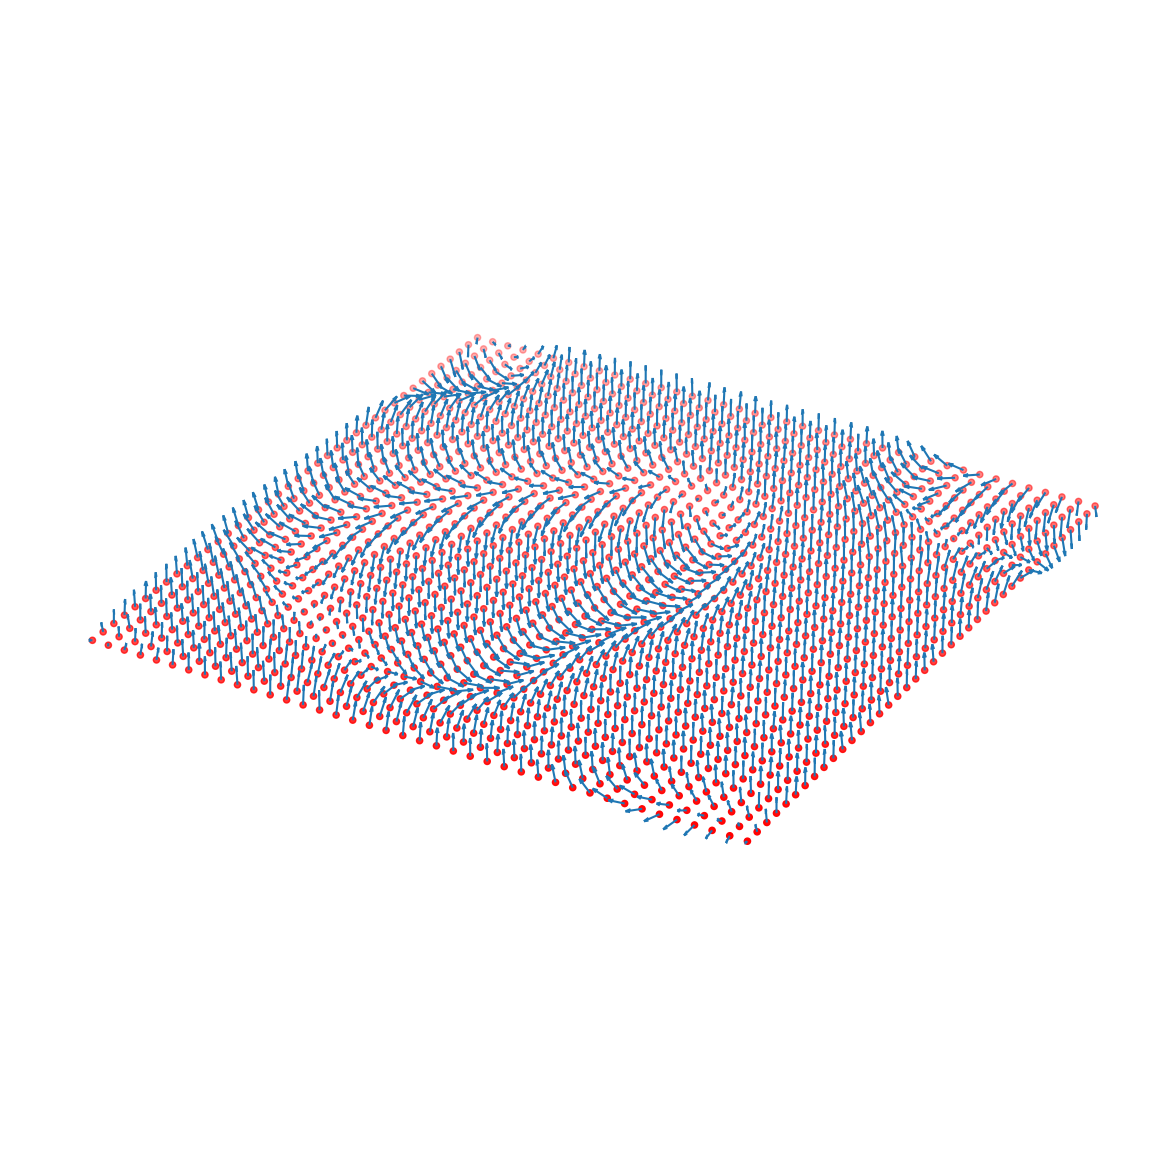

In [22]:
arrowplot = plt.axes(projection='3d')
arrowplot.set_zlim(-1,1)
arrowplot.set_box_aspect(aspect = (length, length, 2))

# make background invisible
arrowplot.axis(False)

# Quiver plot
arrowplot.quiver(
    coords[0],coords[1],coords[2],
    mag[0],mag[1],mag[2]
    )

# Coordinate plot
arrowplot.scatter3D(coords[0],coords[1],coords[2], color='red')

In [23]:
energyList[-1]

-3226.5152063087894

In [24]:
energyExchange(mag)

-3129.3149447694896